# License Plate Detector using MobilenetV3Small SSD

### Load Dataset

In [1]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        img = img.convert("RGB")

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones(num_objs, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor(img_id)
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        if num_objs == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            areas = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            if not isinstance(img, Image.Image):
                img = Image.fromarray(img)
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    # if train:
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    # rescale to 0-1
    transforms.append(T.ToDtype(torch.float, scale=1/255.0))
    # transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(torchvision.transforms.ToTensor())
    return T.Compose(transforms)

In [4]:
# path to your own data and coco file
import utils
train_data_dir = 'data/train'
train_coco = 'data/train/_annotations.coco.json'

test_data_dir = 'data/test'
test_coco = 'data/test/_annotations.coco.json'

valid_data_dir = 'data/valid'
valid_coco = 'data/valid/_annotations.coco.json'

# create own Dataset
train_ds = CustomDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform(train=True)
                          )

test_ds = CustomDataset(root=test_data_dir,
                          annotation=test_coco,
                          transforms=get_transform(train=False)
                          )

valid_ds = CustomDataset(root=valid_data_dir,
                          annotation=valid_coco,
                          transforms=get_transform(train=False)
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 4
test_batch_size = 4
valid_batch_size = 4

# own DataLoader
train_loader = torch.utils.data.DataLoader(train_ds,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          collate_fn=utils.collate_fn)

test_loader = torch.utils.data.DataLoader(test_ds,
                                            batch_size=test_batch_size,
                                            shuffle=False,
                                            collate_fn=utils.collate_fn)

val_loader = torch.utils.data.DataLoader(valid_ds,
                                            batch_size=valid_batch_size,
                                            shuffle=False,
                                            collate_fn=utils.collate_fn)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Done (t=0.03s)
creating index...
index created!


### Baseline model

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [6]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v3_small(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# so we need to add it here
backbone.out_channels = 576 

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
).to(device)

In [7]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def getIoU(bbox, gt):
    x1, y1, w1, h1 = bbox
    x2, y2, w2, h2 = gt
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1+w1, x2+w2)
    yB = min(y1+h1, y2+h2)
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = w1 * h1
    boxBArea = w2 * h2
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# mean average precision
def get_mAP(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels):
    # get mAP
    pred = [{'boxes': pred_boxes, 'labels': pred_labels, 'scores': pred_scores}]
    gt = [{'boxes': gt_boxes, 'labels': gt_labels}]
    map_metric = MeanAveragePrecision(iou_thresholds=[0.5], class_metrics=True)
    map_metric.update(pred, gt)
    mAP = map_metric.compute()
    return mAP['map']


def validate(model, data_loader, device):
    model.eval()
    average_IoU = 0

    mAP = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            pred = model(images)
            pred_boxes = pred[0]['boxes'].cpu()
            pred_labels = pred[0]['labels'].cpu()
            pred_scores = pred[0]['scores'].cpu()
            
            gt_boxes = targets[0]['boxes'].cpu()
            gt_labels = targets[0]['labels'].cpu()
            # get mAP
            if(len(pred_boxes) == 0):
                continue
            mAP += get_mAP(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels)
            pred_boxes = pred[0]['boxes'].cpu().numpy()
            pred_labels = pred[0]['labels'].cpu().numpy()
            pred_scores = pred[0]['scores'].cpu().numpy()

            gt_boxes = targets[0]['boxes'].cpu().numpy()
            gt_labels = targets[0]['labels'].cpu().numpy()

            # get IoU
            if(len(pred_boxes) == 0):
                continue
            iou = getIoU(pred_boxes[0], gt_boxes[0])
            average_IoU += iou

    average_IoU /= len(data_loader)
    mAP /= len(data_loader)

    return average_IoU, mAP

In [8]:
from engine import train_one_epoch, evaluate

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 10
max_IoU = 0
history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    logger = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    history.append(logger)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    IoU, mAP = validate(model, val_loader, device=device)
    print(f"IoU: {IoU}, mAP: {mAP}", )

    if IoU > max_IoU:
        max_IoU = IoU
        model_name = f"FasterRCNN_MobileNetV3_320FPN_2_large_{max_IoU:.3f}.pth"
        torch.save(model.state_dict(), model_name)

    # evaluate(model, val_loader, device=device)

print("That's it!")

d:\Tugazz\Coolyeah\VISKOM\TUBES\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/301]  eta: 0:14:11  lr: 0.000022  loss: 2.3511 (2.3511)  loss_classifier: 0.5882 (0.5882)  loss_box_reg: 0.0004 (0.0004)  loss_objectness: 0.7152 (0.7152)  loss_rpn_box_reg: 1.0473 (1.0473)  time: 2.8298  data: 0.1816  max mem: 2370
Epoch: [0]  [ 10/301]  eta: 0:03:20  lr: 0.000188  loss: 2.1005 (2.0503)  loss_classifier: 0.5540 (0.5316)  loss_box_reg: 0.0004 (0.0022)  loss_objectness: 0.7071 (0.7063)  loss_rpn_box_reg: 0.8040 (0.8103)  time: 0.6878  data: 0.1485  max mem: 2499
Epoch: [0]  [ 20/301]  eta: 0:02:35  lr: 0.000355  loss: 1.8089 (1.8418)  loss_classifier: 0.3770 (0.3908)  loss_box_reg: 0.0031 (0.0124)  loss_objectness: 0.6930 (0.6895)  loss_rpn_box_reg: 0.7653 (0.7491)  time: 0.4387  data: 0.1248  max mem: 2502
Epoch: [0]  [ 30/301]  eta: 0:02:17  lr: 0.000521  loss: 1.4981 (1.7020)  loss_classifier: 0.1454 (0.3101)  loss_box_reg: 0.0315 (0.0262)  loss_objectness: 0.6430 (0.6580)  loss_rpn_box_reg: 0.6878 (0.7076)  time: 0.4055  data: 0.1132  max mem: 2502


## Evaluate

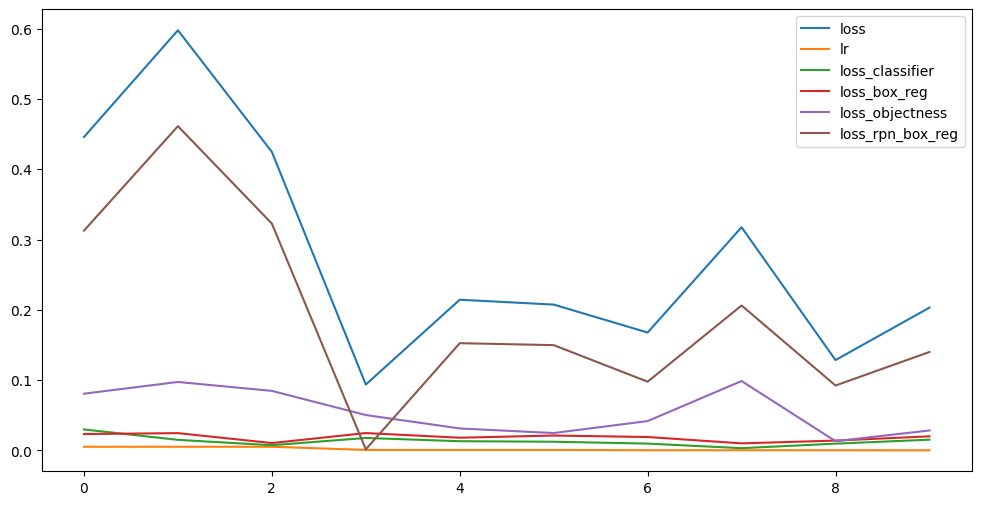

In [9]:
# plot the history
import matplotlib.pyplot as plt
import numpy as np

losses = [x.meters['loss'].value for x in history]
lr = [x.meters['lr'].value for x in history]
loss_classifier = [x.meters['loss_classifier'].value for x in history]
loss_box_reg = [x.meters['loss_box_reg'].value for x in history]
loss_objectness = [x.meters['loss_objectness'].value for x in history]
loss_rpn_box_reg = [x.meters['loss_rpn_box_reg'].value for x in history]


plt.figure(figsize=(12, 6))
plt.plot(losses, label='loss')
plt.plot(lr, label='lr')
plt.plot(loss_classifier, label='loss_classifier')
plt.plot(loss_box_reg, label='loss_box_reg')
plt.plot(loss_objectness, label='loss_objectness')
plt.plot(loss_rpn_box_reg, label='loss_rpn_box_reg')
plt.legend()
plt.show()

In [11]:
test_model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
).to(device)
test_model.load_state_dict(torch.load('FasterRCNN_MobileNetV3_320FPN_2_large_0.902.pth'))
test_model.eval()
print("Model loaded")

C:\Users\Axioo Pongo\AppData\Local\Temp\ipykernel_3980\1931170392.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load('FasterRCNN_Mobil

Model loaded


In [12]:
from PIL import ImageDraw
# evaluate label predictions
def evaluate_label_predictions(model, data_loader, device):
    model.eval()
    accuracy = 0
    fail_img_count = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            pred = model(images)
            pred_boxes = pred[0]['boxes'].cpu().numpy()
            pred_labels = pred[0]['labels'].cpu().numpy()
            pred_scores = pred[0]['scores'].cpu().numpy()

            gt_boxes = targets[0]['boxes'].cpu().numpy()
            gt_labels = targets[0]['labels'].cpu().numpy()

            # print(f"Predicted: {pred_labels[0]}, {pred_scores[0]:.2f}, {pred_boxes[0]}")
            # print(f"Ground truth: {gt_labels[0]}, {gt_boxes[0]}")


            if len(pred_labels) > 0 and len(gt_labels) > 0:
                if pred_labels[0] == gt_labels[0]:
                    accuracy += 1
            else:
                # save failed image
                img = images[0].cpu().numpy()
                img = np.moveaxis(img, 0, -1)
                img = (img * 255).astype(np.uint8)
                img = Image.fromarray(img)
                # draw ground truth
                for i in range(len(gt_boxes)):
                    gt_box = gt_boxes[i]
                    draw = ImageDraw.Draw(img)
                    draw.rectangle(gt_box, outline="green", width=2)

                fail_img_count += 1
                img.save(f"./failed_image/t_failed_image_{fail_img_count}.png")

    accuracy /= len(data_loader)
    return accuracy

accuracy = evaluate_label_predictions(test_model, train_loader, device)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.993


In [16]:
from PIL import Image, ImageDraw 

# predict one image
image, target = test_loader.dataset[5]
with torch.no_grad():
    prediction = test_model([image.to(device)])[0]

    mAP = get_mAP(
        prediction["boxes"].cpu(), 
        prediction["labels"].cpu(), 
        prediction["scores"].cpu(),
          target["boxes"], 
          target["labels"]
          )
    print(mAP)
    # get the predicted bounding boxes
    pred_boxes = prediction["boxes"].cpu().numpy()
    # get the predicted labels
    pred_labels = prediction["labels"].cpu().numpy()
    # get the predicted scores
    pred_scores = prediction["scores"].cpu().numpy()
    # get the ground truth bounding boxes
    gt_boxes = target["boxes"].numpy()
    # get the ground truth labels
    gt_labels = target["labels"].numpy()
    # get the ground truth areas
    gt_areas = target["area"].numpy()
    # get the ground truth iscrowd
    gt_iscrowd = target["iscrowd"].numpy()
    # get the ground truth image_id
    gt_image_id = target["image_id"].numpy()
    # get the IoU
    iou = getIoU(pred_boxes[0], gt_boxes[0])
    img = Image.fromarray(image.mul(255).permute(1, 2, 0).byte().numpy())
    #show bbox
    draw = ImageDraw.Draw(img)
    draw.rectangle([(pred_boxes[0][0], pred_boxes[0][1]), (pred_boxes[0][2], pred_boxes[0][3])], outline ="red", width=3)
    draw.rectangle([(gt_boxes[0][0], gt_boxes[0][1]), (gt_boxes[0][2], gt_boxes[0][3])], outline ="green", width=3)
    img.show()

    print(iou)
    print(pred_scores)

tensor(1.)
0.8082165
[0.7073571  0.65321493 0.56694365 0.4053722  0.40529385 0.3929301
 0.36285755 0.2927966  0.12999898 0.11712529]


In [17]:
# evaluate model
IoU, mAP = validate(test_model, test_loader, device=device)

print(IoU, mAP)

0.83520967 tensor(0.8510)


In [12]:
#save model
torch.save(model.state_dict(), 'model.pth')